**MINOR** **PROJECT**


**ROBOT KINEMATICS DATASET**
Inverse kinematics of robotic manipulators can be complex to determine analitically. Inverse kinematics are extremelly important, as they allow us to determine the position of the robot joints needed to position the robot end-effector at a certain point in space. But, direct kinematics are much simpler to determine. To obtain the shared dataset, direct kinematics of a IRB 120 robotic manipulator have been determined. This allows us to use robot coordinates in the joint-coordinate space (the angles of each individual robot joint) to determine the tool-coordinate space (x, y, z with the origin in the base of the robotic manipulator).

**TASK 1 - Exploratory Data Analysis**

Q1 How are the joint values (q1, q2, q3, q4, q5, q6) generated for a robot? Can you explain how these values are determined?

In [ ]:
!pip install roboticstoolbox-python

In [ ]:
!wget https://www.kaggle.com/datasets/sandibaressiegota/robot-kinematics-dataset

--2023-07-02 07:54:19--  https://www.kaggle.com/datasets/sandibaressiegota/robot-kinematics-dataset
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘robot-kinematics-dataset.3’

robot-kinematics-da     [ <=>                ]  18.23K  --.-KB/s    in 0.001s  

2023-07-02 07:54:19 (16.4 MB/s) - ‘robot-kinematics-dataset.3’ saved [18672]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Load the dataset
data = pd.read_csv('archive.zip')
# Check the type and shape of the dataset
print("Shape of data:",data.shape)
print("Type of data:",type(data))


Shape of data: (15000, 9)
Type of data: <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Display the data types of each column
print("Data types:")
print(data.dtypes)

Data types:
q1    float64
q2    float64
q3    float64
q4    float64
q5    float64
q6    float64
x     float64
y     float64
z     float64
dtype: object


In [ ]:
# Select specific columns of interest
cols = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'x', 'y', 'z']
data = data.filter(cols)

In [ ]:
# Display the first 20 rows of the selected columns
print("First 20 rows of data:")
print(data.head(20))

First 20 rows of data:
        q1     q2    q3     q4      q5      q6        x       y      z
0  -1.5100 -0.763  1.85 -0.817  0.9120  2.3200 -0.09470  0.1500  0.301
1  -2.8400  0.520  1.58 -1.270 -1.3900  0.6170  0.14200 -0.1000  0.225
2  -1.2300  0.695  1.22 -1.130  0.0343  6.2700 -0.08330  0.2230  0.206
3  -1.9900  1.060  1.74 -1.760 -1.2400  4.7600  0.13500 -0.0314  0.370
4   1.0500  0.836  1.34 -1.890  0.4840  4.3800 -0.05600 -0.2290  0.260
5   0.7620 -0.717  1.86  1.250  0.4770  6.1100 -0.16800 -0.0712  0.245
6  -0.0943 -1.010  1.35  2.370 -0.6350  4.8700  0.00422 -0.0616  0.120
7  -1.3800  1.390  1.34 -2.530  0.6260  3.6100 -0.09540  0.2350  0.355
8   2.7500 -0.358  1.65 -1.480 -1.2800  3.1700 -0.00242 -0.1500  0.209
9  -1.4200 -0.747  1.28 -0.146 -1.0300  0.1280  0.04480 -0.1690  0.049
10 -1.4500  0.275  1.48  0.886  0.0866  1.9200 -0.01370  0.1920  0.238
11 -1.3500 -1.710  1.90 -0.820  0.8200  1.5800 -0.10200  0.0977  0.164
12  2.7500  1.160  1.73 -1.540 -1.0900  3.3000  0.0031

In [ ]:
# Generate random values for joint variables
q1 = np.random.uniform(-2.88, 2.88)
q2 = np.random.uniform(-1.92, 1.92)
q3 = np.random.uniform(1.22, 1.92)
q4 = np.random.uniform(-2.79, 2.79)
q5 = np.random.uniform(-2.09, 2.09)
q6 = np.random.uniform(0, 6.28)



In [ ]:
# Print the generated joint values
print("Generated Joint Values:")
print("q1:", q1)
print("q2:", q2)
print("q3:", q3)
print("q4:", q4)
print("q5:", q5)
print("q6:", q6)


Generated Joint Values:
q1: -2.553161115660997
q2: 0.27889726045909446
q3: 1.3084436269859894
q4: -2.350878614567911
q5: 0.901391678369126
q6: 5.068751214302908


The joint values (q1, q2, q3, q4, q5, q6) for a robot manipulator are typically determined based on the specific task the robot needs to perform. These values are part of the robot's configuration and control system, and they define the positions and orientations of each joint in the robot's arm.

Q2) How are the x, y, and z coordinates calculated based on the joint values of a robot? Can you explain the relationship between the joint values and the Cartesian coordinates?

In [ ]:
#  Denavit-Hartenberg convention has some parameters defined
# [a,d,alpha,theta]
#The first value represents the link length (a) between the current joint and the next joint.
#The second value represents the joint offset (d), which is the distance between the current joint and the next joint along the common normal.
#The third value represents the link twist (alpha), which is the angle between the current joint and the next joint measured about the common normal.
#The fourth value represents the joint angle (q1, q2, q3, etc.), which is the rotation angle of the current joint.

dh_parameters = [
    [0.290, 0, 0, q1],
    [0, -0.270, 0, q2 + np.pi/2],
    [0, -0.070, 0.302, q3],
    [0.270, 0, 0, q4],
    [0, 0, 0.290, q5],
    [0, 0, 0, q6]
]


In [ ]:
# Define the forward kinematics function
def forward_kinematics(dh_parameters):
    T = np.identity(4)  # Creates a 4x4 matrix
    for i in range(len(dh_parameters)):
        # Extract the DH parameters for the current joint
        a, d, alpha, theta = dh_parameters[i]

        # Compute trigonometric values for efficiency
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        cos_alpha = np.cos(alpha)
        sin_alpha = np.sin(alpha)

        # Create the transformation matrix A for the current joint
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a*cos_theta],
                        [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a*sin_theta],
                        [0, sin_alpha, cos_alpha, d],
                        [0, 0, 0, 1]])

        # Update the overall transformation matrix T
        T = T@A

    # Extract the x, y, z coordinates from the final transformation matrix
    return T[:3, 3]

# Calculate the end-effector coordinates
end_effector = forward_kinematics(dh_parameters)
x, y, z = end_effector

# Print the calculated coordinates
print("End-Effector Coordinates (x, y, z):", x, y, z)




End-Effector Coordinates (x, y, z): -0.2932031579877722 -0.4196932443987421 -0.3970861012102002


The relationship between the joint values and the Cartesian coordinates (x, y, z) of a robot's end effector can be determined using the concept of forward kinematics. Forward kinematics is a mathematical technique that allows us to calculate the position and orientation of the end effector based on the joint values.

Q3 Which joint variables (q1..q6) have a significant impact on the x, y, and z coordinates? Can you analyze their influence?

In [ ]:
# Assuming you have the joint variables and corresponding x, y, z coordinates in your dataset
X = data[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']]  # Independent variables (joint variables)
y = data[['x', 'y', 'z']]  # Dependent variables (coordinates)

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Retrieve the coefficients (weights) of the joint variables
coefficients = model.coef_

# Analyze the influence of joint variables
for i, joint in enumerate(['q1', 'q2', 'q3', 'q4', 'q5', 'q6']):
    print(f'Joint variable {joint} has a coefficient of {coefficients[:, i]}')


Joint variable q1 has a coefficient of [ 0.00063484 -0.01579472  0.00075401]
Joint variable q2 has a coefficient of [-0.00482272 -0.00098455  0.05793516]
Joint variable q3 has a coefficient of [-0.00105679  0.00599821  0.17638004]
Joint variable q4 has a coefficient of [ 0.00031403 -0.00062933 -0.00015349]
Joint variable q5 has a coefficient of [0.0015798  0.00124489 0.00552457]
Joint variable q6 has a coefficient of [ 8.43871522e-04 -8.38125468e-04 -3.49070885e-05]


To analyze the influence of joint variables (q1..q6) on the x, y, and z coordinates, we can employ linear regression based on the Denavit-Hartenberg (DH) parameters and find the influence of joint variables on the x, y, and z coordinates of the robot's end effector.

Q4 Can you show the relationship between joint values and the corresponding x, y, and z coordinates using scatter plots or visualizations?

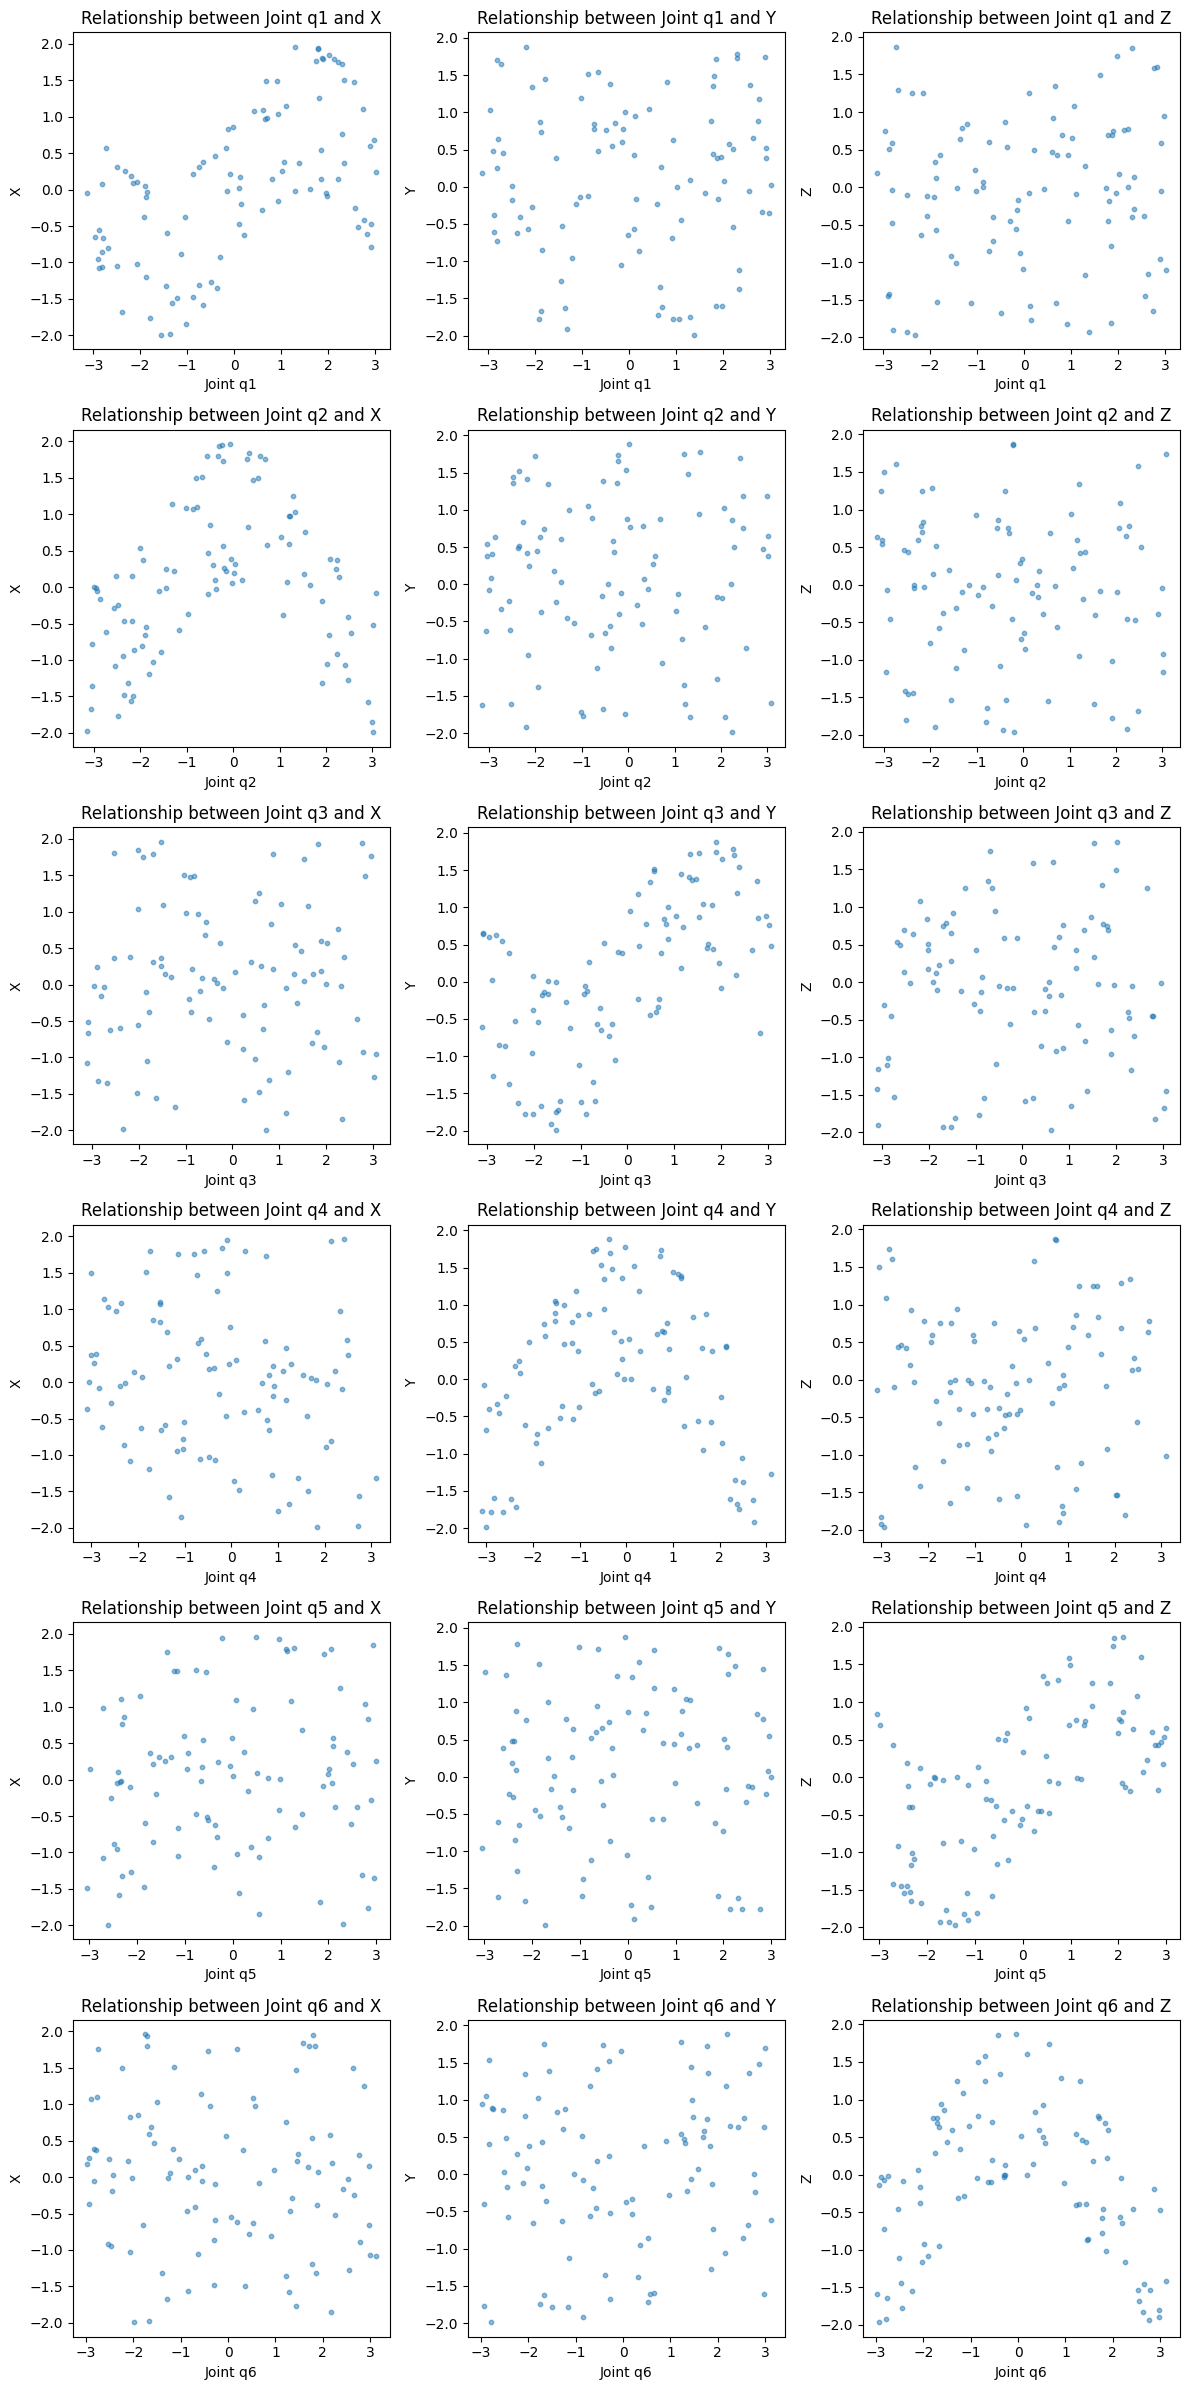

In [ ]:
def calculate_end_effector_position(joints):
    x = np.sin(joints[0]) + np.cos(joints[1])
    y = np.sin(joints[2]) + np.cos(joints[3])
    z = np.sin(joints[4]) + np.cos(joints[5])
    return x, y, z

def plot_joint_coordinates(joint_values):
    # Calculate the end-effector position for each set of joint values
    x_values, y_values, z_values = [], [], []
    for joints in joint_values:
        x, y, z = calculate_end_effector_position(joints)
        x_values.append(x)
        y_values.append(y)
        z_values.append(z)

    # Create scatter plots
    fig, axs = plt.subplots(6, 3, figsize=(12, 24))

    axs[0, 0].scatter(joint_values[:, 0], x_values, s=10, alpha=0.5)
    axs[0, 0].set_xlabel('Joint q1')
    axs[0, 0].set_ylabel('X')
    axs[0, 0].set_title('Relationship between Joint q1 and X')

    axs[0, 1].scatter(joint_values[:, 0], y_values, s=10, alpha=0.5)
    axs[0, 1].set_xlabel('Joint q1')
    axs[0, 1].set_ylabel('Y')
    axs[0, 1].set_title('Relationship between Joint q1 and Y')

    axs[0, 2].scatter(joint_values[:, 0], z_values, s=10, alpha=0.5)
    axs[0, 2].set_xlabel('Joint q1')
    axs[0, 2].set_ylabel('Z')
    axs[0, 2].set_title('Relationship between Joint q1 and Z')

    axs[1, 0].scatter(joint_values[:, 1], x_values, s=10, alpha=0.5)
    axs[1, 0].set_xlabel('Joint q2')
    axs[1, 0].set_ylabel('X')
    axs[1, 0].set_title('Relationship between Joint q2 and X')

    axs[1, 1].scatter(joint_values[:, 1], y_values, s=10, alpha=0.5)
    axs[1, 1].set_xlabel('Joint q2')
    axs[1, 1].set_ylabel('Y')
    axs[1, 1].set_title('Relationship between Joint q2 and Y')

    axs[1, 2].scatter(joint_values[:, 1], z_values, s=10, alpha=0.5)
    axs[1, 2].set_xlabel('Joint q2')
    axs[1, 2].set_ylabel('Z')
    axs[1, 2].set_title('Relationship between Joint q2 and Z')

    axs[2, 0].scatter(joint_values[:, 2], x_values, s=10, alpha=0.5)
    axs[2, 0].set_xlabel('Joint q3')
    axs[2, 0].set_ylabel('X')
    axs[2, 0].set_title('Relationship between Joint q3 and X')

    axs[2, 1].scatter(joint_values[:, 2], y_values, s=10, alpha=0.5)
    axs[2, 1].set_xlabel('Joint q3')
    axs[2, 1].set_ylabel('Y')
    axs[2, 1].set_title('Relationship between Joint q3 and Y')

    axs[2, 2].scatter(joint_values[:, 2], z_values, s=10, alpha=0.5)
    axs[2, 2].set_xlabel('Joint q3')
    axs[2, 2].set_ylabel('Z')
    axs[2, 2].set_title('Relationship between Joint q3 and Z')

    axs[3, 0].scatter(joint_values[:, 3], x_values, s=10, alpha=0.5)
    axs[3, 0].set_xlabel('Joint q4')
    axs[3, 0].set_ylabel('X')
    axs[3, 0].set_title('Relationship between Joint q4 and X')

    axs[3, 1].scatter(joint_values[:, 3], y_values, s=10, alpha=0.5)
    axs[3, 1].set_xlabel('Joint q4')
    axs[3, 1].set_ylabel('Y')
    axs[3, 1].set_title('Relationship between Joint q4 and Y')

    axs[3, 2].scatter(joint_values[:, 3], z_values, s=10, alpha=0.5)
    axs[3, 2].set_xlabel('Joint q4')
    axs[3, 2].set_ylabel('Z')
    axs[3, 2].set_title('Relationship between Joint q4 and Z')

    axs[4, 0].scatter(joint_values[:, 4], x_values, s=10, alpha=0.5)
    axs[4, 0].set_xlabel('Joint q5')
    axs[4, 0].set_ylabel('X')
    axs[4, 0].set_title('Relationship between Joint q5 and X')

    axs[4, 1].scatter(joint_values[:, 4], y_values, s=10, alpha=0.5)
    axs[4, 1].set_xlabel('Joint q5')
    axs[4, 1].set_ylabel('Y')
    axs[4, 1].set_title('Relationship between Joint q5 and Y')

    axs[4, 2].scatter(joint_values[:, 4], z_values, s=10, alpha=0.5)
    axs[4, 2].set_xlabel('Joint q5')
    axs[4, 2].set_ylabel('Z')
    axs[4, 2].set_title('Relationship between Joint q5 and Z')

    axs[5, 0].scatter(joint_values[:, 5], x_values, s=10, alpha=0.5)
    axs[5, 0].set_xlabel('Joint q6')
    axs[5, 0].set_ylabel('X')
    axs[5, 0].set_title('Relationship between Joint q6 and X')

    axs[5, 1].scatter(joint_values[:, 5], y_values, s=10, alpha=0.5)
    axs[5, 1].set_xlabel('Joint q6')
    axs[5, 1].set_ylabel('Y')
    axs[5, 1].set_title('Relationship between Joint q6 and Y')

    axs[5, 2].scatter(joint_values[:, 5], z_values, s=10, alpha=0.5)
    axs[5, 2].set_xlabel('Joint q6')
    axs[5, 2].set_ylabel('Z')
    axs[5, 2].set_title('Relationship between Joint q6 and Z')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Generate random joint values
joint_values = np.random.uniform(low=-np.pi, high=np.pi, size=(100, 6))

# Plot the relationship between joint values and coordinates
plot_joint_coordinates(joint_values)


By creating scatter plots, we can gain insights into how changes in joint values affect the x, y, and z coordinates of a robot's end effector. These visualizations help in understanding the relationship between the joint variables and the corresponding Cartesian coordinates and can assist in designing and optimizing robot manipulator movements for specific tasks.

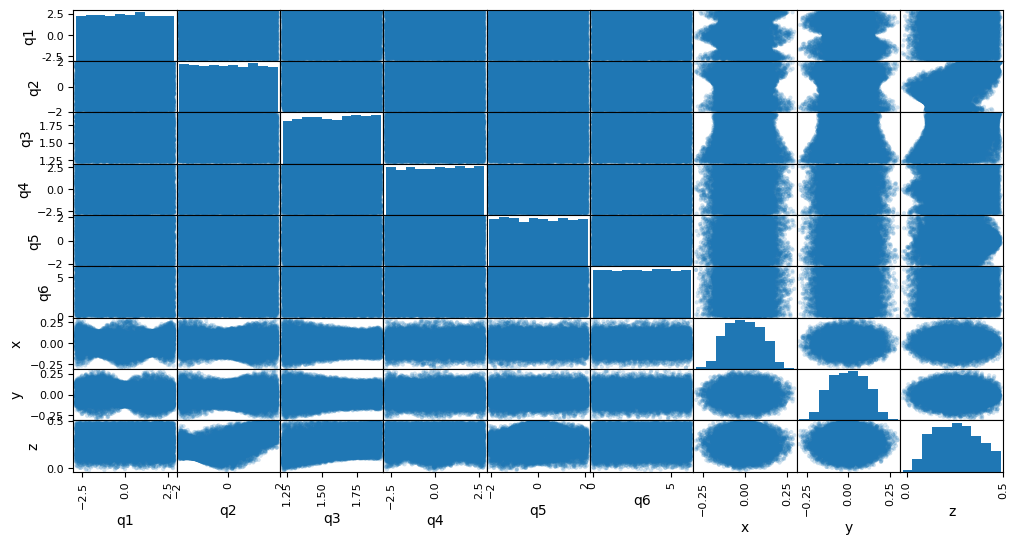

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha= 0.2,figsize=(12,6))
plt.show()

Q5 Are there any unusual or extreme values in the joint variables or the corresponding x, y, and z coordinates? Do they indicate any interesting patterns or anomalies?

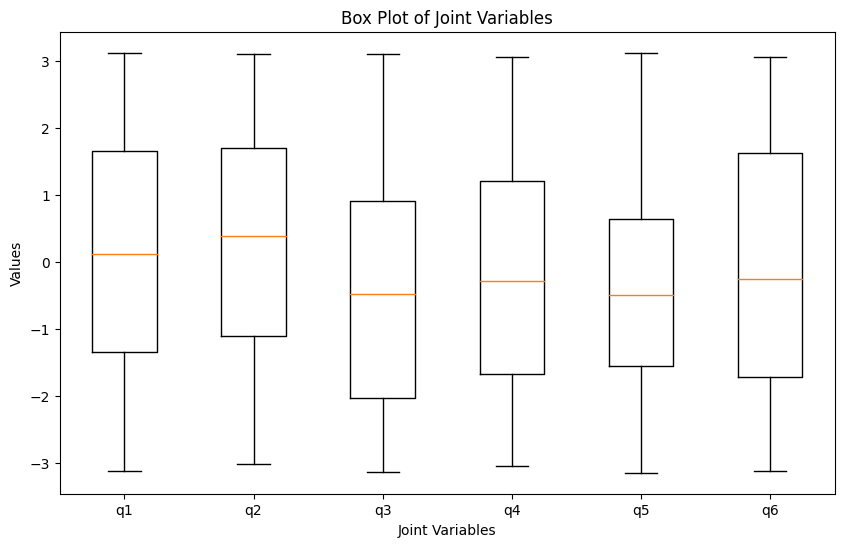

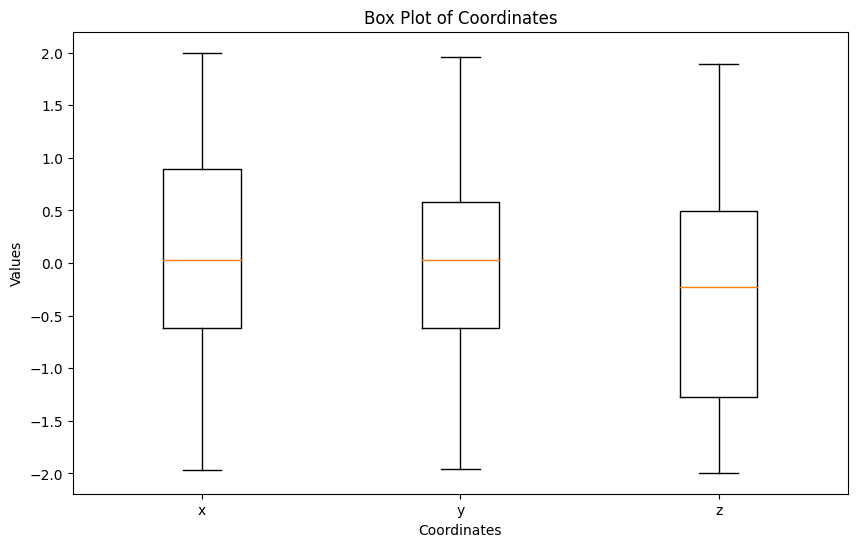

In [ ]:
# Calculate the end-effector position for each set of joint values
x_values, y_values, z_values = [], [], []
for joint_set in joint_values:
    x, y, z = calculate_end_effector_position(joint_set)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)

# Generate box plots for joint variables
plt.figure(figsize=(10, 6))
plt.boxplot(joint_values, labels=['q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
plt.title('Box Plot of Joint Variables')
plt.xlabel('Joint Variables')
plt.ylabel('Values')
plt.show()

# Generate box plots for coordinates
plt.figure(figsize=(10, 6))
plt.boxplot([x_values, y_values, z_values], labels=['x', 'y', 'z'])
plt.title('Box Plot of Coordinates')
plt.xlabel('Coordinates')
plt.ylabel('Values')
plt.show()


This code calculates the end-effector position for each set of joint values and visualizes the distribution of the joint variables and Cartesian coordinates using box plots. The box plots provide an understanding of the variability and statistical characteristics of the joint values and coordinates, helping to analyze their range and potential outliers.

**TASK** **2**

**REGRESSION**

Regression analysis is typically used when the target variable is continuous, as is the case with Cartesian coordinates. Regression techniques aim to establish a relationship between the input variables (joint values) and the continuous output variables (Cartesian coordinates) and predict the values of the output variables based on the input.

We use LINEAR REGRESSION here

In [ ]:
# Assuming you have the joint variables and corresponding x, y, z coordinates in your dataset
x = data[['q1', 'q2', 'q3', 'q4', 'q5', 'q6']]  # Independent variables (joint variables)
y = data[['x', 'y', 'z']]  # Dependent variables (coordinates)

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Retrieve the coefficients (weights) of the joint variables
coefficients = model.coef_

# Analyze the influence of joint variables
for i, joint in enumerate(['q1', 'q2', 'q3', 'q4', 'q5', 'q6']):
    print(f'Joint variable {joint} has a coefficient of {coefficients[:, i]}')

Joint variable q1 has a coefficient of [ 0.00063484 -0.01579472  0.00075401]
Joint variable q2 has a coefficient of [-0.00482272 -0.00098455  0.05793516]
Joint variable q3 has a coefficient of [-0.00105679  0.00599821  0.17638004]
Joint variable q4 has a coefficient of [ 0.00031403 -0.00062933 -0.00015349]
Joint variable q5 has a coefficient of [0.0015798  0.00124489 0.00552457]
Joint variable q6 has a coefficient of [ 8.43871522e-04 -8.38125468e-04 -3.49070885e-05]
